In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

In [3]:
dfs = {}
for name in ['train', 'test']:
    df = pd.read_csv('../data/%s.csv' % name)
    df['_data'] = name
    dfs[name] = df

In [4]:
# combine train and test data into one df
df = dfs['train'].append(dfs['test'])

# lowercase column names
df.columns = map(str.lower, df.columns)

# parse datetime colum & add new time related columns
dt = pd.DatetimeIndex(df['datetime'])
df.set_index(dt, inplace=True)

In [5]:
# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'count']:
    df['%s_log' % col] = np.log(df[col] + 1)

In [6]:
df['date'] = dt.date
df['day'] = dt.day
df['month'] = dt.month
df['year'] = dt.year
df['hour'] = dt.hour
df['dow'] = dt.dayofweek
df['woy'] = dt.weekofyear

In [7]:
# interpolate weather, atemp, humidity
df["weather"] = df["weather"].interpolate(method='time').apply(np.round)
df["temp"] = df["temp"].interpolate(method='time')
df["atemp"] = df["atemp"].interpolate(method='time')
df["humidity"] = df["humidity"].interpolate(method='time').apply(np.round)
df["windspeed"] = df["windspeed"].interpolate(method='time')

In [8]:
# add a count_season column using join
by_season = df[df['_data'] == 'train'].groupby('season')[['count']].agg(sum)
by_season.columns = ['count_season']
df = df.join(by_season, on='season')

print by_season

        count_season
season              
1             312498
2             588282
3             640662
4             544034


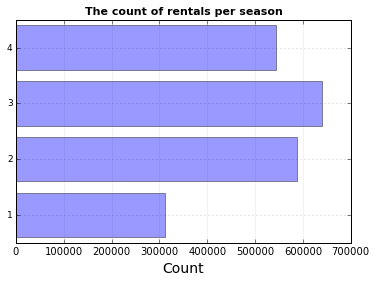

In [9]:
xticks = list(by_season.index)

#plotting
plt.barh([x for x in range(len(xticks))], list(by_season['count_season']), align='center', alpha=0.4)
plt.yticks([x for x in range(len(xticks))], xticks, fontsize=9)

plt.xlabel("Count", fontsize=14)
plt.title("The count of rentals per season", fontsize=11, fontweight='bold')
plt.gca().xaxis.grid(True,linestyle='-',alpha=0.1)
plt.gca().yaxis.grid(True,alpha=0.4)

In [10]:
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# tax day
df.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
df.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# thanksgiving friday
df.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
df.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
# tax day
df.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
df.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
df.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
df.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1

#storms
df.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#tornado
df.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

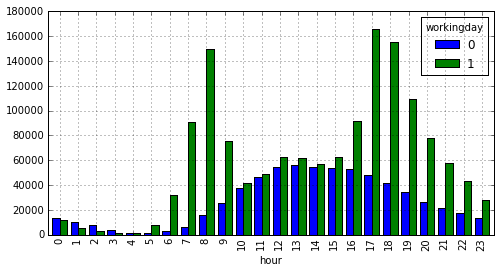

In [11]:
# rentals by hour, split by working day (or not)
by_hour = df[df['_data'] == 'train'].copy().groupby(['hour', 'workingday'])['count'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);

In [12]:
df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

In [13]:
#sandy
df['holiday'] = df[['month', 'day', 'holiday', 'year']].apply(lambda x: (x['holiday'], 1)[x['year'] == 2012 and x['month'] == 10 and (x['day'] in [30])], axis = 1)

#christmas day and others
df['holiday'] = df[['month', 'day', 'holiday']].apply(lambda x: (x['holiday'], 1)[x['month'] == 12 and (x['day'] in [24, 26, 31])], axis = 1)
df['workingday'] = df[['month', 'day', 'workingday']].apply(lambda x: (x['workingday'], 0)[x['month'] == 12 and x['day'] in [24, 31]], axis = 1)

In [14]:
df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)

In [15]:
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)


def get_data():
    data = df[df['_data'] == 'train'].copy()
    return data


def custom_train_test_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    test = data[data['day'] > cutoff_day]

    return train, test


def prep_data(data, input_cols):
    X = data[input_cols].as_matrix()
    y_r = data['registered_log'].as_matrix()
    y_c = data['casual_log'].as_matrix()

    return X, y_r, y_c


def predict_on_validation_set(model, input_cols):
    data = get_data()

    train, test = custom_train_test_split(data)

    X_train, y_train_r, y_train_c = prep_data(train, input_cols)
    X_test, y_test_r, y_test_c = prep_data(test, input_cols)

    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_test)) - 1

    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_test)) - 1

    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0

    y_test_comb = np.exp(y_test_r) + np.exp(y_test_c) - 2

    score = get_rmsle(y_pred_comb, y_test_comb)
    return (y_pred_comb, y_test_comb, score)

df_test = df[df['_data'] == 'test'].copy()

# predict on test set & transform output back from log scale
def predict_on_test_set(model, x_cols):
    # prepare training set
    df_train = df[df['_data'] == 'train'].copy()
    X_train = df_train[x_cols].as_matrix()
    y_train_cas = df_train['casual_log'].as_matrix()
    y_train_reg = df_train['registered_log'].as_matrix()

    # prepare test set
    X_test = df_test[x_cols].as_matrix()

    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1
    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1
    # add casual & registered predictions together
    return y_pred_cas + y_pred_reg

In [16]:
params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dow', 'woy', 'peak'
    ]

rf_pred = predict_on_test_set(rf_model, rf_cols)
(rf_p, rf_t, rf_score) = predict_on_validation_set(rf_model, rf_cols)
print rf_score

0.440013955161


In [17]:
df[rf_cols].corr()

,weather,temp,atemp,windspeed,workingday,season,holiday,sticky,hour,dow,woy,peak
weather,1.000000,-0.102640,-0.105563,0.026226,0.042061,-0.014524,0.026336,0.243523,-0.020203,-0.046424,0.009692,-0.006856
temp,-0.102640,1.000000,0.987672,-0.023125,0.069153,0.312025,-0.070342,-0.007074,0.137603,-0.036220,0.198641,0.094661
atemp,-0.105563,0.987672,1.000000,-0.062336,0.067594,0.319380,-0.072605,0.004717,0.133750,-0.038918,0.205561,0.089266
windspeed,0.026226,-0.023125,-0.062336,1.000000,-0.001937,-0.149773,-0.005298,-0.187671,0.137252,0.003274,-0.131613,0.132339
workingday,0.042061,0.069153,0.067594,-0.001937,1.000000,0.010879,-0.240847,0.536900,0.002185,-0.698028,-0.025700,-0.268954
season,-0.014524,0.312025,0.319380,-0.149773,0.010879,1.000000,-0.032516,0.095556,-0.006117,-0.007448,0.814302,-0.003620
holiday,0.026336,-0.070342,-0.072605,-0.005298,-0.240847,-0.032516,1.000000,-0.109330,0.003451,-0.169788,0.081117,0.058081
sticky,0.243523,-0.007074,0.004717,-0.187671,0.536900,0.095556,-0.109330,1.000000,-0.186289,-0.399949,0.096672,-0.218378
hour,-0.020203,0.137603,0.133750,0.137252,0.002185,-0.006117,0.003451,-0.186289,1.000000,-0.002893,-0.005437,0.216209
dow,-0.046424,-0.036220,-0.038918,0.003274,-0.698028,-0.007448,-0.169788,-0.399949,-0.002893,1.000000,0.009368,0.191317


In [18]:
params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
gbm_model = GradientBoostingRegressor(**params)
gbm_cols = [
    'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'dow', 'year', 'ideal', 'count_season',
]

gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
(gbm_p, gbm_t, gbm_score) = predict_on_validation_set(gbm_model, gbm_cols)
print gbm_score

0.314312605221


In [19]:
df[gbm_cols].corr()

,weather,temp,atemp,humidity,windspeed,holiday,workingday,season,hour,dow,year,ideal,count_season
weather,1.000000,-0.102640,-0.105563,0.418130,0.026226,0.026336,0.042061,-0.014524,-0.020203,-0.046424,-0.019157,-0.145407,-0.051863
temp,-0.102640,1.000000,0.987672,-0.069881,-0.023125,-0.070342,0.069153,0.312025,0.137603,-0.036220,0.040913,0.727266,0.705172
atemp,-0.105563,0.987672,1.000000,-0.051918,-0.062336,-0.072605,0.067594,0.319380,0.133750,-0.038918,0.039222,0.701874,0.701434
humidity,0.418130,-0.069881,-0.051918,1.000000,-0.290105,0.012676,0.014316,0.150625,-0.276498,-0.035233,-0.083546,-0.141678,0.113724
windspeed,0.026226,-0.023125,-0.062336,-0.290105,1.000000,-0.005298,-0.001937,-0.149773,0.137252,0.003274,-0.008740,-0.051489,-0.113048
holiday,0.026336,-0.070342,-0.072605,0.012676,-0.005298,1.000000,-0.240847,-0.032516,0.003451,-0.169788,0.029875,-0.022858,-0.091034
workingday,0.042061,0.069153,0.067594,0.014316,-0.001937,-0.240847,1.000000,0.010879,0.002185,-0.698028,-0.007959,0.023068,0.044535
season,-0.014524,0.312025,0.319380,0.150625,-0.149773,-0.032516,0.010879,1.000000,-0.006117,-0.007448,-0.010742,0.156455,0.663537
hour,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.003451,0.002185,-0.006117,1.000000,-0.002893,-0.003867,0.113745,-0.008248
dow,-0.046424,-0.036220,-0.038918,-0.035233,0.003274,-0.169788,-0.698028,-0.007448,-0.002893,1.000000,0.000977,-0.009208,-0.014472


In [20]:
# the blend gives a better score on the leaderboard, even though it does not on the validation set
y_p = np.round(.2*rf_p + .8*gbm_p)
print get_rmsle(y_p, rf_t)

0.318794846858


In [21]:
y_pred = np.round(.2*rf_pred + .8*gbm_pred)
# output predictions for submission
df_test['count'] = y_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('../output/submit.csv', index=False)

Used https://github.com/brendansudol/kaggle-bike-share/blob/master/ipy-notebooks/main.ipynb as starting point for this notebook.